In [ ]:
# 0 - Setup & load
from datasets import load_dataset
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, lit, sum as spark_sum
from pyspark.sql.types import *
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
spark = SparkSession.builder.appName("TelcomAssignment").enableHiveSupport().getOrCreate()

In [ ]:
# Load dataset (HuggingFace)
ds = load_dataset("aai510-group1/telco-customer-churn")
df = ds["train"].to_pandas()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4225 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1409 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1409 [00:00<?, ? examples/s]

In [ ]:

# Convert to PySpark
df_spark = spark.createDataFrame(df)
print("Initial schema and sample:")
df_spark.printSchema()

Initial schema and sample:
root
 |-- Age: long (nullable = true)
 |-- Avg Monthly GB Download: long (nullable = true)
 |-- Avg Monthly Long Distance Charges: double (nullable = true)
 |-- Churn: long (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)
 |-- Churn Score: long (nullable = true)
 |-- City: string (nullable = true)
 |-- CLTV: long (nullable = true)
 |-- Contract: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Dependents: long (nullable = true)
 |-- Device Protection Plan: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Internet Service: long (nullable = true)
 |-- Internet Type: string (nullable = true)
 |-- Lat Long: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Married: long (nullable = true)
 |-- Monthly Charge: double (null

In [ ]:
df_spark.show(5, truncate=False)

+---+-----------------------+---------------------------------+-----+---------------+-------------------+-----------+------------+----+--------------+-------------+-----------+---------------+----------+----------------------+------+----------------+-------------+----------------------+---------+-----------+-------+--------------+--------------+--------------------+-------------------+-------+-------------+---------------+-----------------+-------+---------------+-------------+----------+--------------------+-------+-----------------+------------------+--------------+----------+----------------+---------------+------------+----------------+-------------+------------------------+---------------------------+-------------+-------------+--------+--------------+--------+
|Age|Avg Monthly GB Download|Avg Monthly Long Distance Charges|Churn|Churn Category |Churn Reason       |Churn Score|City        |CLTV|Contract      |Country      |Customer ID|Customer Status|Dependents|Device Protection Pl

In [ ]:
# 1 - Add required fields (simulate missing ones) and basic cleaning
locations = ["Kathmandu", "Lalitpur", "Bhaktapur", "Pokhara", "Chitwan",
             "Butwal", "Biratnagar", "Dharan", "Hetauda", "Janakpur"]

In [ ]:
# Rename messy columns to clean names
df_spark = df_spark.withColumnRenamed("Customer ID", "CustomerID") \
                   .withColumnRenamed("Monthly Charge", "MonthlyCharges") \
                   .withColumnRenamed("Churn", "ChurnIndicator")  # keep original values (Yes/No or 0/1 depending on dataset)

In [ ]:
# Simulate CallDuration, DataUsage, Location, Complaints, ServicePlan (from Contract)
# Use Age and MonthlyCharges as proxies to simulate realistic values
df_feat = df_spark.withColumn("CustomerID", col("CustomerID")) \
    .withColumn("CallDuration", (col("Age") * lit(random.randint(20, 50))).cast("int")) \
    .withColumn("DataUsage", (col("MonthlyCharges") * 0.5 + lit(random.random() * 5)).cast("float")) \
    .withColumn("Location", lit(random.choice(locations))) \
    .withColumn("ServicePlan", col("Contract")) \
    .withColumn("Complaints", lit(random.randint(0, 8)).cast("int")) \
    .withColumn("ChurnIndicator", col("ChurnIndicator"))

In [ ]:
# Drop duplicates (by CustomerID)
df_feat = df_feat.dropDuplicates(["CustomerID"])

In [ ]:
# Keep only required columns plus a few useful originals for EDA
df_required = df_feat.select(
    "CustomerID", "CallDuration", "DataUsage", "Location", "ServicePlan", "Complaints", "ChurnIndicator",
    "Age", "MonthlyCharges"
)

print("Required columns sample:")
df_required.show(10, truncate=False)

Required columns sample:
+----------+------------+---------+---------+--------------+----------+--------------+---+--------------+
|CustomerID|CallDuration|DataUsage|Location |ServicePlan   |Complaints|ChurnIndicator|Age|MonthlyCharges|
+----------+------------+---------+---------+--------------+----------+--------------+---+--------------+
|0002-ORFBO|1813        |34.225513|Bhaktapur|One Year      |6         |0             |37 |65.6          |
|0003-MKNFE|2254        |31.375515|Bhaktapur|Month-to-Month|6         |0             |46 |59.9          |
|0013-EXCHZ|3675        |43.375515|Bhaktapur|Month-to-Month|6         |1             |75 |83.9          |
|0013-MHZWF|1127        |36.125515|Bhaktapur|Month-to-Month|6         |0             |23 |69.4          |
|0015-UOCOJ|3332        |25.525515|Bhaktapur|Two Year      |6         |0             |68 |48.2          |
|0017-IUDMW|1225        |59.825516|Bhaktapur|Two Year      |6         |0             |25 |116.8         |
|0019-GFNTW|1911     

In [ ]:
df_required.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- CallDuration: integer (nullable = true)
 |-- DataUsage: float (nullable = true)
 |-- Location: string (nullable = false)
 |-- ServicePlan: string (nullable = true)
 |-- Complaints: integer (nullable = false)
 |-- ChurnIndicator: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- MonthlyCharges: double (nullable = true)



In [ ]:
# 2 - Feature engineering
from pyspark.ml.feature import StringIndexer

In [ ]:
# Simulate Tenure if you want (optional)
df_feat = df_feat.withColumn("Tenure", (lit(random.randint(1,72))).cast("int"))

In [ ]:
# SessionCount derived from CallDuration
df_feat = df_feat.withColumn(
    "SessionCount",
    when(col("CallDuration") > 200, 3)
    .when(col("CallDuration") > 100, 2)
    .otherwise(1)
)

In [ ]:
# CongestionRisk (simple rule)
df_feat = df_feat.withColumn(
    "CongestionRisk",
    when(col("DataUsage") > 3.0, "High")
    .when(col("DataUsage") > 1.5, "Medium")
    .otherwise("Low")
)

In [ ]:
# Cost and Profit (simple simulated cost model)
df_feat = df_feat.withColumn("Cost", (col("CallDuration") * 0.02 + col("DataUsage") * 1.5)) \
                 .withColumn("Profit", (col("MonthlyCharges") - col("Cost")))


In [ ]:
#  Encode churn (StringIndexer handles 'Yes'/'No' or '1/0' automatically)
si = StringIndexer(inputCol="ChurnIndicator", outputCol="ChurnLabel", handleInvalid="keep")
df_feat = si.fit(df_feat).transform(df_feat)

In [ ]:
print("Feature-engineered sample:")
df_feat.select("CustomerID","CallDuration","DataUsage","SessionCount","CongestionRisk","Cost","Profit","ChurnIndicator","ChurnLabel").show(10, truncate=False)


Feature-engineered sample:
+----------+------------+---------+------------+--------------+------------------+-------------------+--------------+----------+
|CustomerID|CallDuration|DataUsage|SessionCount|CongestionRisk|Cost              |Profit             |ChurnIndicator|ChurnLabel|
+----------+------------+---------+------------+--------------+------------------+-------------------+--------------+----------+
|2011-TRQYE|2891        |18.175514|3           |High          |85.0832713317871  |-51.5832713317871  |1             |1.0       |
|5802-ADBRC|2793        |53.625515|3           |High          |136.2982724761963 |-31.898272476196297|0             |0.0       |
|0356-ERHVT|2646        |24.375515|3           |High          |89.48327247619629 |-43.58327247619629 |0             |0.0       |
|6383-ZTSIW|3773        |50.975513|3           |High          |151.92327018737794|-52.82327018737794 |0             |0.0       |
|1894-IGFSG|1862        |46.050514|3           |High          |106.315

In [ ]:
# 3 - EDA: missing values, counts, basic stats
print("Schema:")
df_feat.printSchema()

Schema:
root
 |-- Age: long (nullable = true)
 |-- Avg Monthly GB Download: long (nullable = true)
 |-- Avg Monthly Long Distance Charges: double (nullable = true)
 |-- ChurnIndicator: long (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)
 |-- Churn Score: long (nullable = true)
 |-- City: string (nullable = true)
 |-- CLTV: long (nullable = true)
 |-- Contract: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Dependents: long (nullable = true)
 |-- Device Protection Plan: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Internet Service: long (nullable = true)
 |-- Internet Type: string (nullable = true)
 |-- Lat Long: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Married: long (nullable = true)
 |-- MonthlyCharges: double (nullable = true

In [ ]:
print("Total rows:", df_feat.count())

Total rows: 4225


In [ ]:
# Missing values per column
missing = df_feat.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_feat.columns])
print("Missing values per column:")
missing.show(truncate=False)

Missing values per column:
+---+-----------------------+---------------------------------+--------------+--------------+------------+-----------+----+----+--------+-------+----------+---------------+----------+----------------------+------+----------------+-------------+--------+--------+---------+-------+--------------+--------------+--------------------+-------------------+-----+-------------+---------------+-----------------+-------+--------------+-------------+----------+--------------------+-------+-----------------+------------------+--------------+-----+----------------+---------------+------------+----------------+-------------+------------------------+---------------------------+-------------+-------------+--------+--------------+--------+------------+---------+--------+-----------+----------+------+------------+--------------+----+------+----------+
|Age|Avg Monthly GB Download|Avg Monthly Long Distance Charges|ChurnIndicator|Churn Category|Churn Reason|Churn Score|City|CLTV|

In [ ]:
# Handle missing values
from pyspark.sql.functions import col
from pyspark.sql import functions as F

df_clean = df_feat

# Separate numeric + categorical
numeric_cols = [f.name for f in df_clean.schema.fields
                if f.dataType.simpleString() in ["int", "double", "float", "long"]]

categorical_cols = [c for c in df_clean.columns if c not in numeric_cols]

# Fill numeric with median
for c in numeric_cols:
    median_val = df_clean.approxQuantile(c, [0.5], 0.25)[0]
    df_clean = df_clean.fillna({c: median_val})

# Fill categorical with mode
for c in categorical_cols:
    mode_row = df_clean.groupBy(c).count().orderBy(F.desc("count")).first()
    if mode_row and mode_row[c] is not None:
        df_clean = df_clean.fillna({c: mode_row[c]})
    else:
        df_clean = df_clean.fillna({c: "Unknown"})

# Ensure ChurnIndicator is integer
df_clean = df_clean.withColumn("ChurnIndicator", col("ChurnIndicator").cast("int"))


In [ ]:
df_clean.show()

+---+-----------------------+---------------------------------+--------------+---------------+--------------------+-----------+----------------+----+--------------+-------------+----------+---------------+----------+----------------------+------+----------------+-------------+--------------------+---------+-----------+-------+--------------+--------------+--------------------+-------------------+-------+-------------+---------------+-----------------+-------+---------------+-------------+----------+--------------------+-------+-----------------+------------------+--------------+----------+----------------+---------------+------------+----------------+-------------+------------------------+---------------------------+-------------+-------------+--------+--------------+--------+------------+---------+---------+--------------+----------+------+------------+--------------+------------------+-------------------+----------+
|Age|Avg Monthly GB Download|Avg Monthly Long Distance Charges|Churn

In [ ]:
print("Cleaned data schema")
df_required_clean = df_clean.select(
    "CustomerID",
    "CallDuration",
    "DataUsage",
    "Location",
    "ServicePlan",
    "Complaints",
    "ChurnIndicator",
    "SessionCount",
    "CongestionRisk",
    "Cost",
    "Profit",
    "ChurnLabel"
)

print("Required clean fields (After Missing Value Handling)")
df_required_clean.show(20)


Cleaned data schema
Required clean fields (After Missing Value Handling)
+----------+------------+---------+---------+--------------+----------+--------------+------------+--------------+------------------+-------------------+----------+
|CustomerID|CallDuration|DataUsage| Location|   ServicePlan|Complaints|ChurnIndicator|SessionCount|CongestionRisk|              Cost|             Profit|ChurnLabel|
+----------+------------+---------+---------+--------------+----------+--------------+------------+--------------+------------------+-------------------+----------+
|0002-ORFBO|        1813|34.225513|Bhaktapur|      One Year|         6|             0|           3|          High| 87.59827018737792|-21.998270187377926|       0.0|
|0003-MKNFE|        2254|31.375515|Bhaktapur|Month-to-Month|         6|             0|           3|          High| 92.14327247619629| -32.24327247619629|       0.0|
|0013-EXCHZ|        3675|43.375515|Bhaktapur|Month-to-Month|         6|             1|           3|   

In [ ]:
from pyspark.sql.functions import sum, col

print("Verify no miising value reamains")
df_clean.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df_clean.columns
]).show()


Verify no miising value reamains
+---+-----------------------+---------------------------------+--------------+--------------+------------+-----------+----+----+--------+-------+----------+---------------+----------+----------------------+------+----------------+-------------+--------+--------+---------+-------+--------------+--------------+--------------------+-------------------+-----+-------------+---------------+-----------------+-------+--------------+-------------+----------+--------------------+-------+-----------------+------------------+--------------+-----+----------------+---------------+------------+----------------+-------------+------------------------+---------------------------+-------------+-------------+--------+--------------+--------+------------+---------+--------+-----------+----------+------+------------+--------------+----+------+----------+
|Age|Avg Monthly GB Download|Avg Monthly Long Distance Charges|ChurnIndicator|Churn Category|Churn Reason|Churn Score|City

In [ ]:
# Basic numeric summary (select numeric columns)
numeric_cols = ["CallDuration", "DataUsage", "MonthlyCharges", "Complaints", "SessionCount", "Cost", "Profit"]
print("Numeric summary:")
df_clean.select(numeric_cols).describe().show()

Numeric summary:
+-------+------------------+------------------+-----------------+----------+------------+------------------+-------------------+
|summary|      CallDuration|         DataUsage|   MonthlyCharges|Complaints|SessionCount|              Cost|             Profit|
+-------+------------------+------------------+-----------------+----------+------------+------------------+-------------------+
|  count|              4225|              4225|             4225|      4225|        4225|              4225|               4225|
|   mean|2276.1050887573965| 33.87874558014277|64.90646153846147|       6.0|         3.0| 96.34022014536204|-31.433758606900533|
| stddev| 819.8443789617057|14.963006936373898|29.92601355923216|       0.0|         0.0| 29.59060420988342|  17.04408553800179|
|    min|               931|         10.550514|            18.25|         6|           3|35.383271331787114|  -75.7382719039917|
|    max|              3920|         60.800514|           118.75|         6|    

In [ ]:
# Categorical distributions (example)
for c in ["Location", "ServicePlan", "CongestionRisk", "ChurnIndicator"]:
    print(f"Value counts for {c}:")
    df_clean.groupBy(c).count().orderBy(col("count").desc()).show(10)

Value counts for Location:
+---------+-----+
| Location|count|
+---------+-----+
|Bhaktapur| 4225|
+---------+-----+

Value counts for ServicePlan:
+--------------+-----+
|   ServicePlan|count|
+--------------+-----+
|Month-to-Month| 2193|
|      Two Year| 1128|
|      One Year|  904|
+--------------+-----+

Value counts for CongestionRisk:
+--------------+-----+
|CongestionRisk|count|
+--------------+-----+
|          High| 4225|
+--------------+-----+

Value counts for ChurnIndicator:
+--------------+-----+
|ChurnIndicator|count|
+--------------+-----+
|             0| 3104|
|             1| 1121|
+--------------+-----+



In [ ]:
# 4 - Visual EDA (collect small tables to pandas)
plot_pd = df_clean.select(
    "ChurnIndicator","ChurnLabel","Location","CongestionRisk",
    "ServicePlan","Profit","CallDuration","DataUsage","Complaints"
).toPandas()

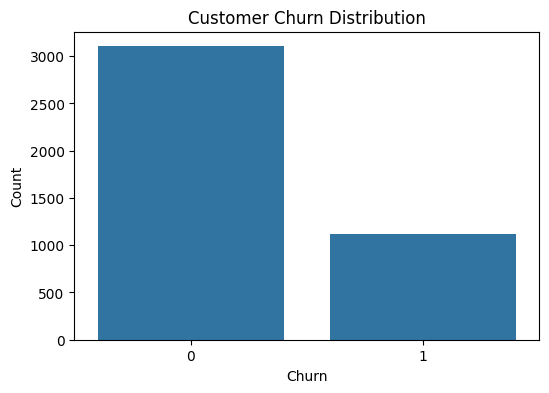

In [ ]:
# 4.1 churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x="ChurnIndicator", data=plot_pd)
plt.title("Customer Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

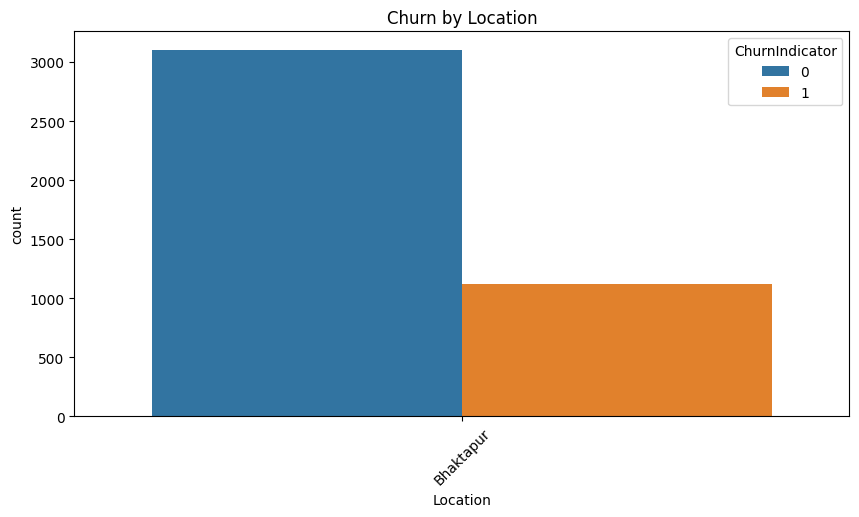

In [ ]:
# 4.2 churn by location
plt.figure(figsize=(10,5))
sns.countplot(x="Location", hue="ChurnIndicator", data=plot_pd)
plt.xticks(rotation=45)
plt.title("Churn by Location")
plt.show()

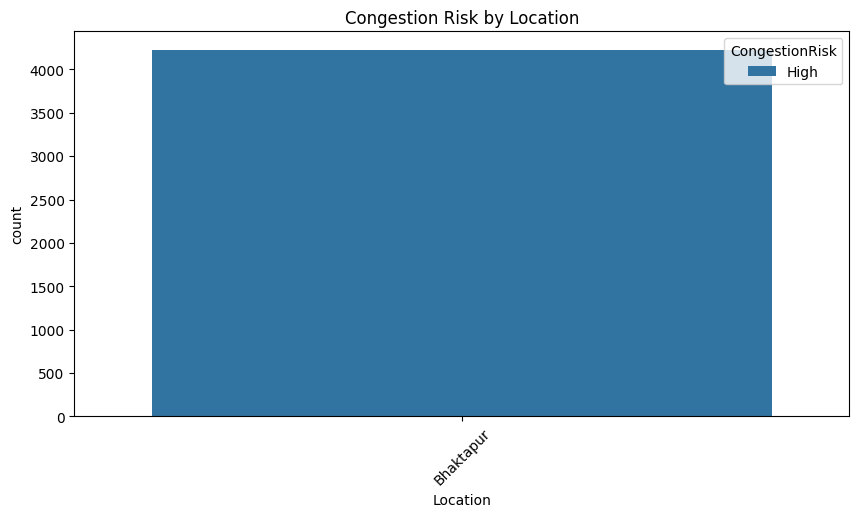

In [ ]:
# 4.3 congestion risk by location
plt.figure(figsize=(10,5))
sns.countplot(x="Location", hue="CongestionRisk", data=plot_pd)
plt.xticks(rotation=45)
plt.title("Congestion Risk by Location")
plt.show()

/tmp/ipython-input-1204381623.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ServicePlan", y="AvgProfit", data=profit_pd, ci=None)


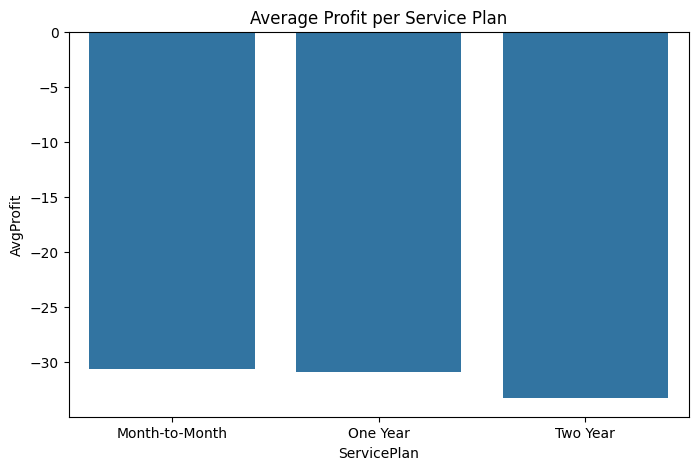

In [ ]:
 #4.4 profit per service plan
profit_pd = df_clean.groupBy("ServicePlan").agg(avg("Profit").alias("AvgProfit")).toPandas()
plt.figure(figsize=(8,5))
sns.barplot(x="ServicePlan", y="AvgProfit", data=profit_pd, ci=None)
plt.title("Average Profit per Service Plan")
plt.show()

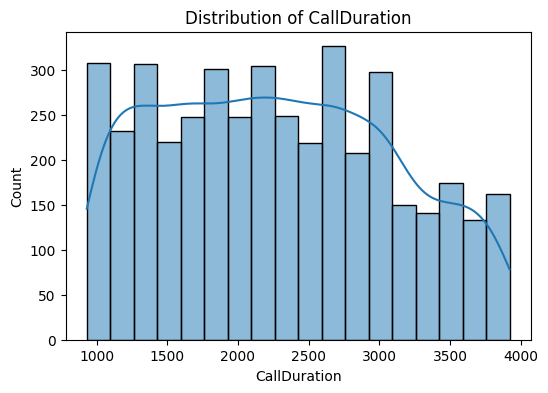

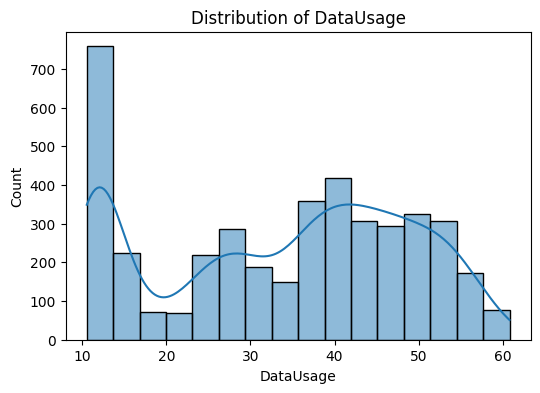

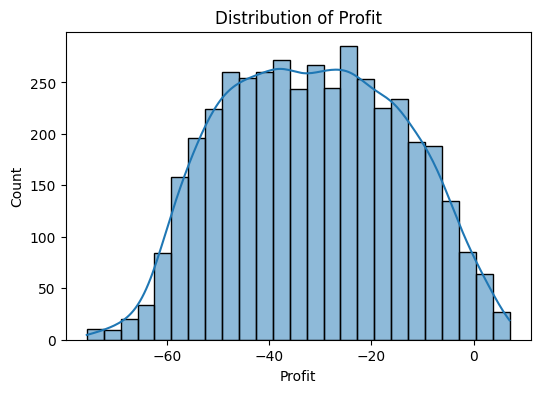

In [ ]:
# 4.5 numeric distributions
for colname in ["CallDuration","DataUsage","Profit"]:
    plt.figure(figsize=(6,4))
    sns.histplot(plot_pd[colname], kde=True)
    plt.title(f"Distribution of {colname}")
    plt.show()


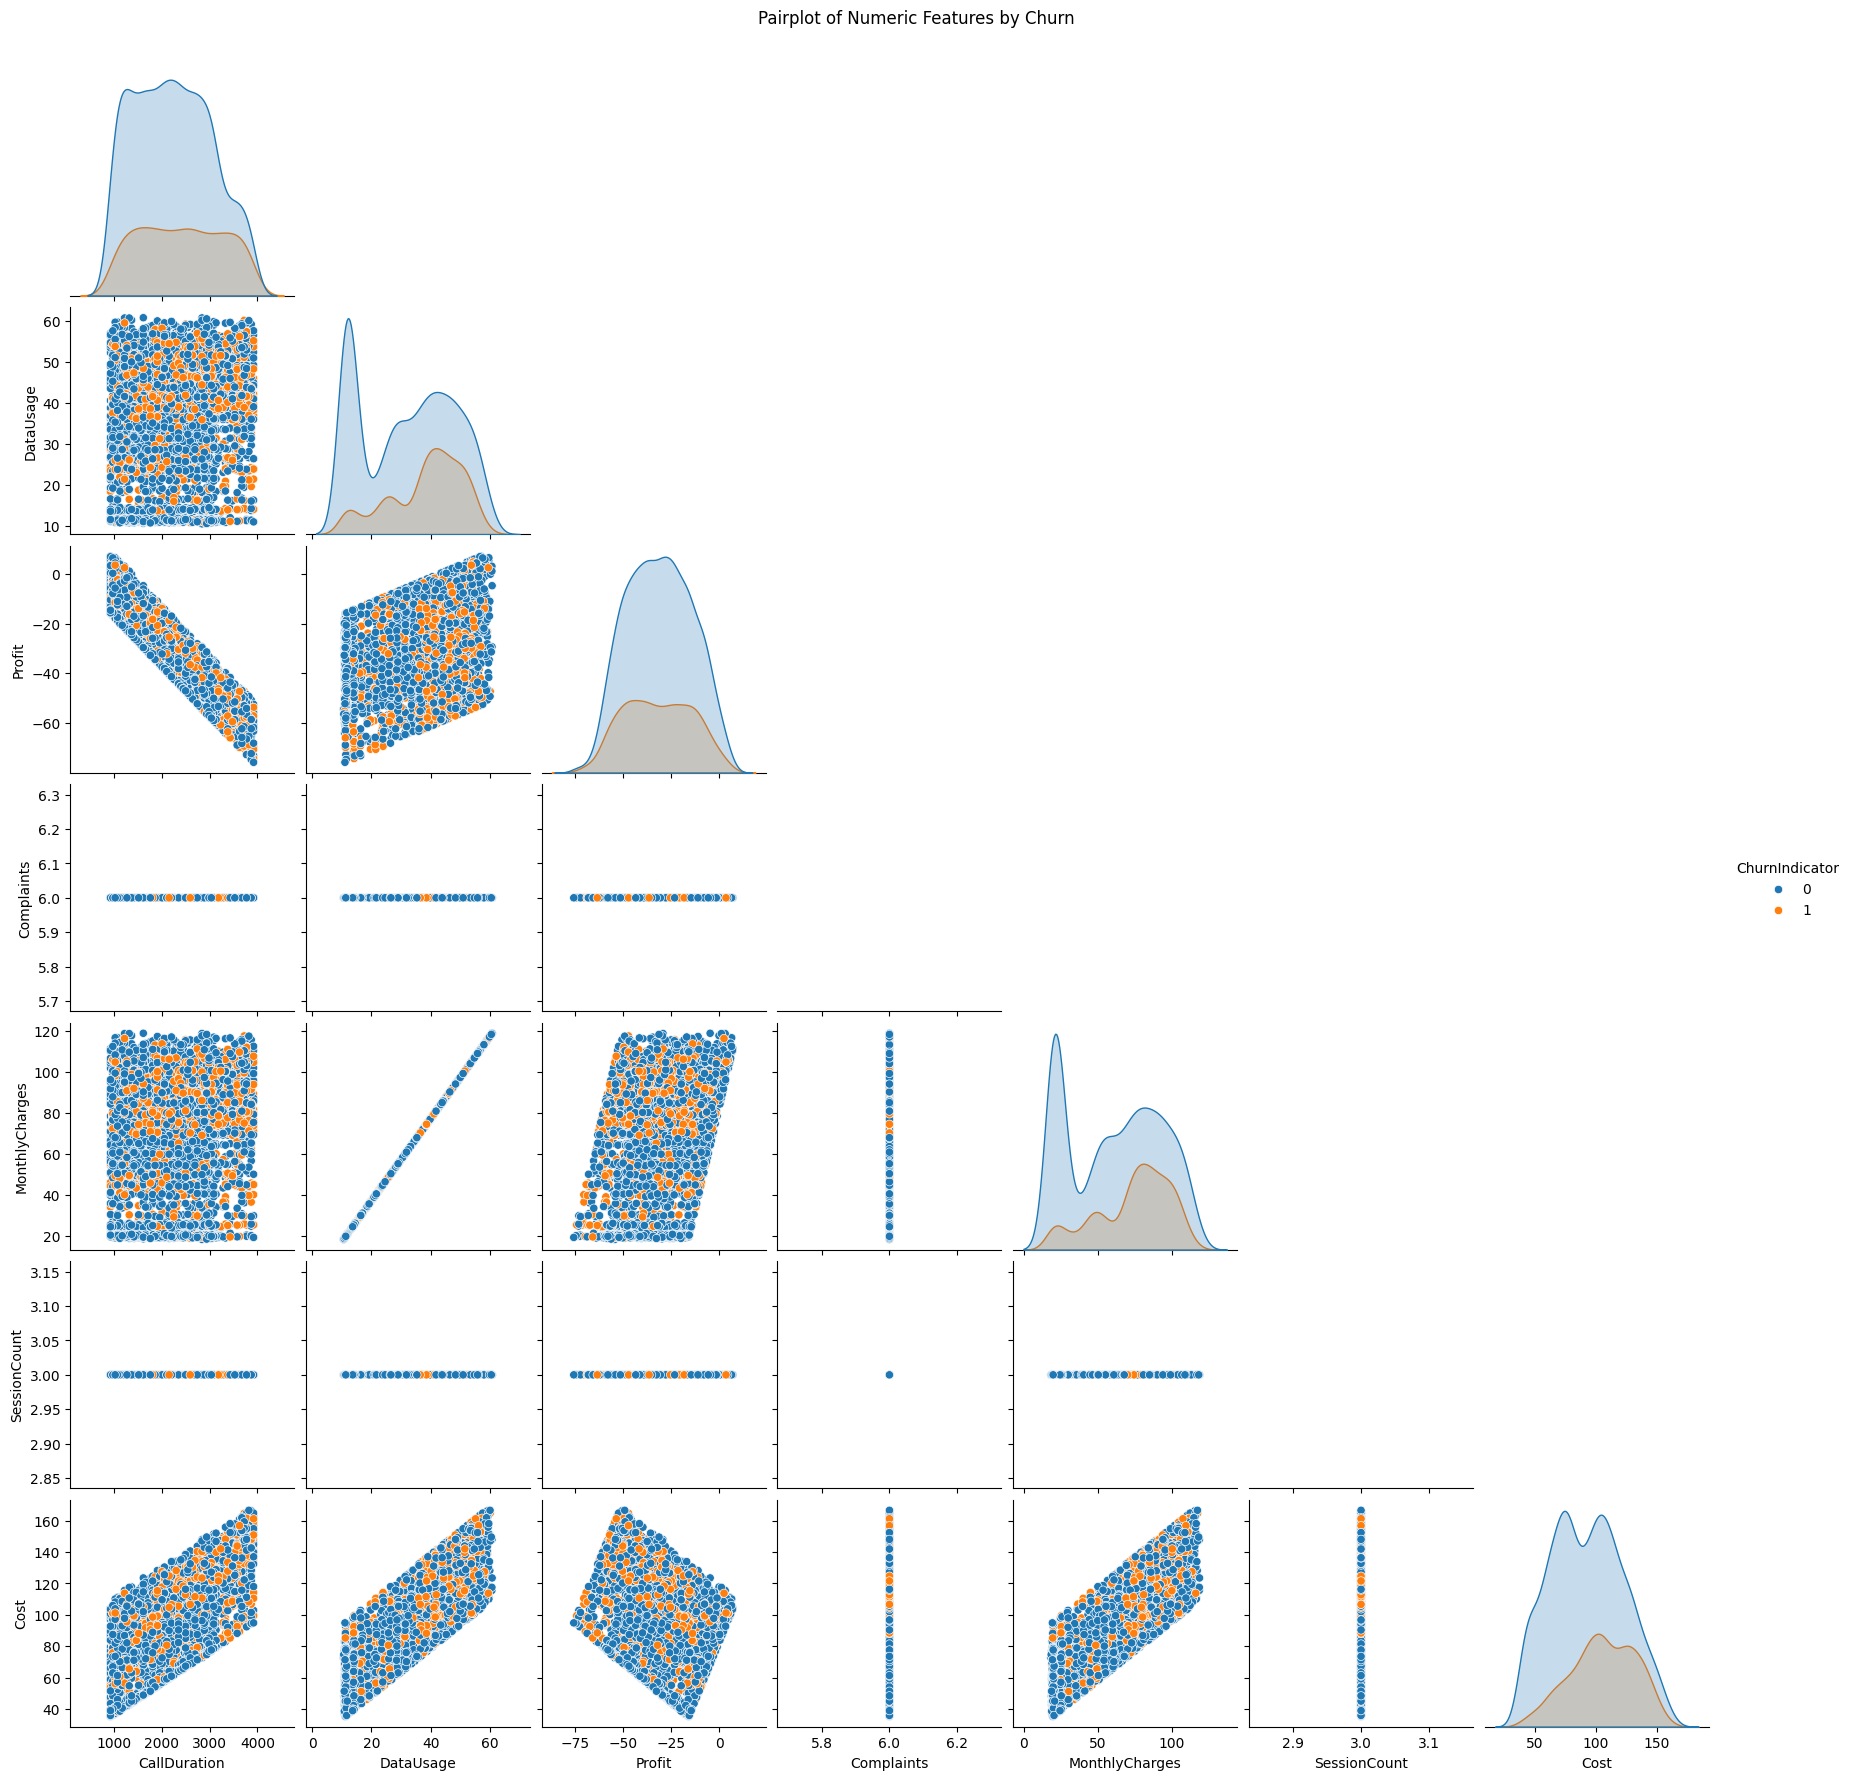

In [ ]:
# Pairplot of numeric features colored by Churn
plot_pd = df_clean.select(
    "ChurnIndicator", "ChurnLabel", "Location", "CongestionRisk", "ServicePlan",
    "Profit", "CallDuration", "DataUsage", "Complaints", "MonthlyCharges", "SessionCount", "Cost"
).toPandas()

numeric_cols = ["CallDuration","DataUsage","Profit","Complaints","MonthlyCharges","SessionCount","Cost"]
sns.pairplot(plot_pd[numeric_cols + ["ChurnIndicator"]], hue="ChurnIndicator", corner=True, diag_kind="kde", height=2.5)
plt.suptitle("Pairplot of Numeric Features by Churn", y=1.02)
plt.show()

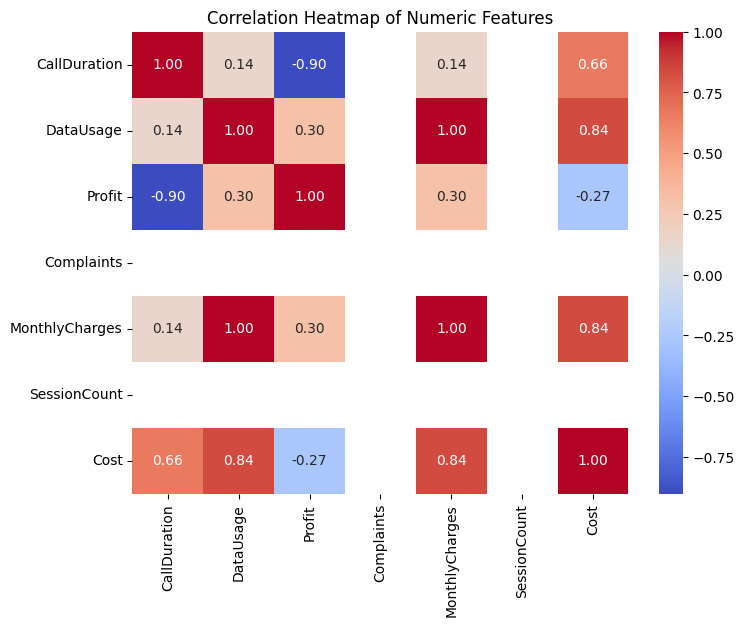

In [ ]:
# Heatmap of correlations
numeric_cols = ["CallDuration","DataUsage","Profit","Complaints","MonthlyCharges","SessionCount","Cost"]
corr_matrix = df_clean.select(numeric_cols).toPandas().corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [ ]:
assembler = VectorAssembler(
    inputCols=["CallDuration","DataUsage","Complaints","MonthlyCharges","SessionCount"],
    outputCol="features"
)

df_model = assembler.transform(df_clean).select("features","ChurnLabel")
train, test = df_model.randomSplit([0.7,0.3], seed=42)
print("Train/test sizes:", train.count(), test.count())

Train/test sizes: 3027 1198


In [ ]:
# 4. Modeling & metrics
models = {
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="ChurnLabel", seed=42),
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="ChurnLabel", maxIter=20),
    "GBT": GBTClassifier(featuresCol="features", labelCol="ChurnLabel", maxIter=50, maxDepth=5, seed=42)
}

In [ ]:
metrics_list = []
for name, model in models.items():
    fitted = model.fit(train)
    pred = fitted.transform(test)
    acc = MulticlassClassificationEvaluator(labelCol="ChurnLabel", predictionCol="prediction", metricName="accuracy").evaluate(pred)
    f1 = MulticlassClassificationEvaluator(labelCol="ChurnLabel", predictionCol="prediction", metricName="f1").evaluate(pred)
    auc = BinaryClassificationEvaluator(labelCol="ChurnLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred)
    metrics_list.append((name, acc, f1, auc))

metrics_df = pd.DataFrame(metrics_list, columns=["Model", "Accuracy", "F1 Score", "AUC"])
print("Model comparison:")
print(metrics_df)

Model comparison:
                 Model  Accuracy  F1 Score       AUC
0        Random Forest  0.728715  0.614358  0.686723
1  Logistic Regression  0.728715  0.614358  0.633437
2                  GBT  0.712020  0.643642  0.663373


In [ ]:
# 5. Confusion matrix (Random Forest example)
rf = RandomForestClassifier(featuresCol="features", labelCol="ChurnLabel", seed=42)
rf_model = rf.fit(train)
pred_rf = rf_model.transform(test)
cm_df = pred_rf.select(col("prediction").cast("int").alias("pred"), col("ChurnLabel").cast("int").alias("label"))
cm_pd = cm_df.groupBy("label","pred").count().toPandas().pivot(index="label", columns="pred", values="count").fillna(0).astype(int)
print("Confusion matrix (rows=true, cols=pred):")
print(cm_pd)

Confusion matrix (rows=true, cols=pred):
pred     0
label     
0      873
1      325


In [ ]:
# 6. Congestion & Profit summaries
print("Congestion by Location:")
df_clean.groupBy("Location","CongestionRisk").count().orderBy("Location").show(100, truncate=False)


Congestion by Location:
+---------+--------------+-----+
|Location |CongestionRisk|count|
+---------+--------------+-----+
|Bhaktapur|High          |4225 |
+---------+--------------+-----+



In [ ]:
print("Average Profit per ServicePlan:")
df_clean.groupBy("ServicePlan").agg(avg("Profit").alias("AvgProfit"), avg("MonthlyCharges").alias("AvgRevenue")).show(truncate=False)

Average Profit per ServicePlan:
+--------------+------------------+-----------------+
|ServicePlan   |AvgProfit         |AvgRevenue       |
+--------------+------------------+-----------------+
|Month-to-Month|-30.66500040322196|65.4176470588235 |
|One Year      |-30.93147466834667|66.76028761061953|
|Two Year      |-33.33087866108468|62.42695035460984|
+--------------+------------------+-----------------+



In [ ]:
# 7. RDD vs DF vs SQL timing
df_clean.createOrReplaceTempView("telecom")

In [ ]:
start = time.time()
rdd_res = df_clean.rdd.map(lambda x: x.CallDuration * 2).take(5)
rdd_time = time.time() - start

start = time.time()
df_res = df_clean.select((col("CallDuration") * 2).alias("CallDuration2")).limit(5).collect()
df_time = time.time() - start

start = time.time()
sql_res = spark.sql("SELECT CallDuration*2 AS CallDuration2 FROM telecom LIMIT 5").collect()
sql_time = time.time() - start

In [ ]:

print("\nSpark operations timing:")
print(f"RDD time: {rdd_time:.6f}s")
print(f"DataFrame time: {df_time:.6f}s")
print(f"SQL time: {sql_time:.6f}s")


Spark operations timing:
RDD time: 1.786859s
DataFrame time: 0.543583s
SQL time: 0.666370s


In [ ]:
import psutil

print("\nCPU Utilization Metrics (Before & After Each Operation):")

# CPU before RDD
cpu_before_rdd = psutil.cpu_percent(interval=1)

# Run RDD operation again for CPU measurement
df_clean.rdd.map(lambda x: x.CallDuration * 2).take(5)

cpu_after_rdd = psutil.cpu_percent(interval=1)
print(f"RDD CPU Before: {cpu_before_rdd}% | After: {cpu_after_rdd}%")


CPU Utilization Metrics (Before & After Each Operation):
RDD CPU Before: 4.5% | After: 17.9%


In [ ]:
# CPU before DataFrame
cpu_before_df = psutil.cpu_percent(interval=1)

df_clean.select((col("CallDuration") * 2)).limit(5).collect()

cpu_after_df = psutil.cpu_percent(interval=1)
print(f"DataFrame CPU Before: {cpu_before_df}% | After: {cpu_after_df}%")

DataFrame CPU Before: 24.1% | After: 9.6%


In [ ]:
# CPU before SQL
cpu_before_sql = psutil.cpu_percent(interval=1)

spark.sql("SELECT CallDuration*2 FROM telecom LIMIT 5").collect()

cpu_after_sql = psutil.cpu_percent(interval=1)
print(f"SQL CPU Before: {cpu_before_sql}% | After: {cpu_after_sql}%")


SQL CPU Before: 3.0% | After: 17.7%


In [ ]:
print("\nScalability Test (increasing data size):")

sizes = [500, 1000, 3000, 6000]
for s in sizes:
    print(f"\nTesting with {s} rows:")

    sample_df = df_clean.limit(s)

    start = time.time()
    sample_df.select(col("CallDuration") * 2).count()
    end = time.time()

    print(f"Time for {s} rows: {end - start:.4f}s")



Scalability Test (increasing data size):

Testing with 500 rows:
Time for 500 rows: 0.6919s

Testing with 1000 rows:
Time for 1000 rows: 0.5415s

Testing with 3000 rows:
Time for 3000 rows: 0.6266s

Testing with 6000 rows:
Time for 6000 rows: 0.4306s


In [ ]:
spark.sql("CREATE DATABASE IF NOT EXISTS telecom_ds")
spark.sql("USE telecom_ds")
df_clean.write.mode("overwrite").saveAsTable("telecom_customers")

In [ ]:
spark.sql("USE telecom_ds")

# Example: top 10 customers by churn
spark.sql("""
SELECT CustomerID, ChurnIndicator
FROM telecom_customers
ORDER BY ChurnIndicator DESC
LIMIT 10
""").show()


+----------+--------------+
|CustomerID|ChurnIndicator|
+----------+--------------+
|0032-PGELS|             1|
|0156-FVPTA|             1|
|0067-DKWBL|             1|
|0115-TFERT|             1|
|0133-BMFZO|             1|
|0022-TCJCI|             1|
|0135-NMXAP|             1|
|0093-XWZFY|             1|
|0148-DCDOS|             1|
|0151-ONTOV|             1|
+----------+--------------+



In [ ]:
# Write CSV to a Colab-friendly Linux path
df_clean.coalesce(1).write.mode("overwrite").option("header", "true").csv("/content/telecom_clean")


In [ ]:
import os
os.listdir("/content/telecom_clean")


['part-00000-4b75b6f7-0759-4f16-9146-2b86439310f8-c000.csv',
 '_SUCCESS',
 '._SUCCESS.crc',
 '.part-00000-4b75b6f7-0759-4f16-9146-2b86439310f8-c000.csv.crc']

In [ ]:
import os
import glob
from google.colab import files

# Path where Spark wrote the CSV folder
folder_path = "/content/telecom_clean"

# List all CSV files inside that folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# There should only be one file if you used coalesce(1)
csv_file = csv_files[0]

# Move/rename to a simple path for download
download_path = "/content/telecom_clean.csv"
os.rename(csv_file, download_path)

# Now download
files.download(download_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>